In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams['font.family'] = ['sans-serif'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False

# 数据
数据由我翻阅 "天马四区2栋学生群" 自 2022-03-10 的聊天记录开始统计, 记录的截止时间是 2022-05-28. 记录的数据是每一天晚归的记录, 由于楼栋是 23:30 关门, 因此定义当天晚于这个时间点回来的同学为晚归. 记录晚归时, 每条记录分为三个字段:
- niickname : 晚归的同学在群里的昵称;
- date : 提出晚归时的日期, 如果是在凌晨提出的晚归, 则改字段值为前一天的日期;
- till : 晚归的时间. 由于记录时并不能完全准确的获取晚归的时间点, 因此记录时主要通过以下方式获得改值:
    - 同学说明的晚归的时间;
    - 同学回来时在群里报告的时间;
    - 根据同学在群里的聊天记录进行推测;
    
数据基本情况:
- 共采集到 125 条数据;
- 共出现了 59 名同学;

数据采集的一些遗漏情况:
- 有些同学没有在群里表达晚归, 比如看到别人说了自己就没说的, 和同学一起回来的;

In [2]:
df = pd.read_csv('data.txt')
df

,nickname,date,till
0,2006-陈宇,03-11,0:30
1,zzT,03-11,1:00
2,赵梦阳-4013,03-12,0:30
3,1001程翔宇,03-12,0:20
4,咸鱼,03-15,3:00
...,...,...,...
171,咸鱼,06-15,0:20
172,咸鱼,06-16,0:20
173,3004-王仁君,06-17,23:55
174,luffy,06-17,0:01


In [3]:
print(df.nickname.nunique(), sorted(df.nickname.unique()))

70 ['1001-戴贤文', '1001程翔宇', '1002-周鑫', '1004向亮', '1008-洪宇杰', '1010-曾城', '1010-羊进', '1011周俊', '2003郝志翔', '2004-李玮翔', '2006-陈宇', '2007-万常俊', '2007-万长俊', '2008-马祥远', '3001-汪嵩洋', '3003周寅童', '3003姜文泽', '3004-王仁君', '3006-张谦祥', '3006-石泽华', '3006tyx', '3007张家豪', '3007王逸探', '3009叶宇航', '3011-李迎宾', '3011超皓', '3012-严浩钦', '3013刘力鸣', '4001唐周莎', '4002-李飞', '4002余琪', '4002马登省', '4003戴京', '4004夏曹明', '4006 李星欢', '4006-聂文凯', '4006耿文达', '4007 周奕琛', '4007 欧海龙', '4008-楚东东', '4008蔡子欣', '4009-秦钒治', '4012-丁俊杰', '4012-夏提', '4012夏提', 'Aurora', 'Lfs', 'S201000912张子宁', 'S2010W0893', 'Z', 'gzy', 'luffy', 'wuyangtao', 'zzT', '不妨不徨，来日方长', '何炳', '刘博', '咸鱼', '大梨', '安吉拉贝比', '崔洪生', '惠盼森', '执剑', '旺仔小刘乃', '易俊1005', '罗维', '訫态', '赵梦阳-4013', '轻语', '黄同学']


# 分析

首先会把 till 字段进行离散化, 虽然本身已经是离散化的值, 但是并不规整. 因此这里会按照每半个小时将 till 字段进行划分, 即:
- [23:30, 24:00) --- 0
- [24:00, 24:30) --- 1
- [24:30, 25:00) --- 2
- [25:00, 25:30) --- 3
- [25:30, 26:00) --- 4
- [26:00, 26:30) --- 5
- [26:30, 27:00) --- 6
- [27:00, 27:30) --- 7

注意以上是 24 小时制的时间, 由于晚归的时间一般分布在第二天的凌晨, 为方便处理数据, 将**第二天的凌晨一点视作前一天的 25 点, 以此类推**. 按照每半个小时, 从 23:30 对时间进行划分, 遵循**左闭右开**的原则. 在以上描述的基础上得到晚归区间, 作为类别变量 **late**. 把 till 字段按照上述进行划分, 落到对应区间, 得到对应样本的晚归类别.


主要分析的内容:
- 每天的晚归人数, 各个类别的晚归人数;
- 每个晚归类别的的频数;
- 晚归次数排名

In [4]:
late_map = {}
late_map[0] = "23:30~24:00"
late_map[1] = "00:00~00:30"
late_map[2] = "00:30~01:00"
late_map[3] = "01:00~01:30"
late_map[4] = "01:30~02:00"
late_map[5] = "02:00~02:30"
late_map[6] = "02:30~03:00"
late_map[7] = "03:00~03:30"

In [5]:
def bucket(v):
    if v < 2400:
        return 0
    elif v < 2430:
        return 1
    elif v < 2500:
        return 2
    elif v < 2530:
        return 3
    elif v < 2600:
        return 4
    elif v < 2630:
        return 5
    elif v < 2700:
        return 6
    elif 2730:
        return 7


def late_cate(till):
    ans = []
    for i, e in enumerate(till):
        # print(i, e)
        tmp = [int(ee) for ee in e.split(':')]
        if tmp[0] != 23:
            tmp[0] = tmp[0] + 24
        tmp = 100*tmp[0] + tmp[1]
        ans.append(bucket(tmp))
        
    return ans

In [6]:
df["late"] = late_cate(df.till)
df["date"] = df["date"].apply(lambda x: "2022-"+x)
df["date"] = pd.to_datetime(df["date"]).apply(lambda x: x.date())
df

,nickname,date,till,late
0,2006-陈宇,2022-03-11,0:30,2
1,zzT,2022-03-11,1:00,3
2,赵梦阳-4013,2022-03-12,0:30,2
3,1001程翔宇,2022-03-12,0:20,1
4,咸鱼,2022-03-15,3:00,7
...,...,...,...,...
171,咸鱼,2022-06-15,0:20,1
172,咸鱼,2022-06-16,0:20,1
173,3004-王仁君,2022-06-17,23:55,0
174,luffy,2022-06-17,0:01,1


In [7]:
start_date = df.date.min()
end_date = df.date.max()
print(start_date, end_date)

2022-03-11 2022-06-18


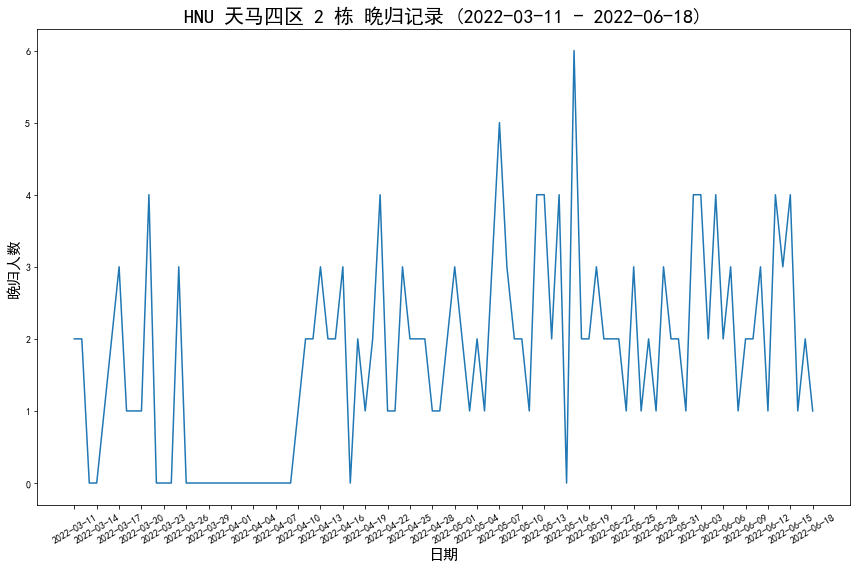

In [8]:
dates = [e.date() for e in pd.date_range(start_date, end_date)]
date_num = dict(zip(dates, [0]*len(dates)))
g_date = df.groupby('date')
tmp = g_date.agg('count')
tmp = dict(zip(tmp.index, tmp["till"].tolist()))
date_num.update(tmp)

date_num = list(date_num.items())
date_num = sorted(date_num, key=lambda x: x[0])
dates, nums = [e[0] for e in date_num], [e[1] for e in date_num]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(nums)
xtk = np.arange(len(dates))
xtl = dates
_ = ax.set_xticks(xtk[::3])
_ = ax.set_xticklabels(xtl[::3], rotation=30)
ax.set_xlabel("日期", fontsize=15)
ax.set_ylabel("晚归人数", fontsize=15)
ax.set_title(f"HNU 天马四区 2 栋 晚归记录 ({start_date} - {end_date})", fontsize=20)
fig.tight_layout()

fig.savefig("output/"+ f"{start_date}~{end_date}" + "晚归人数-日期.png", dpi=400)

Text(0.5, 1.0, 'HNU 天马四区 2 栋 晚归记录 (2022-03-11 - 2022-06-18)')

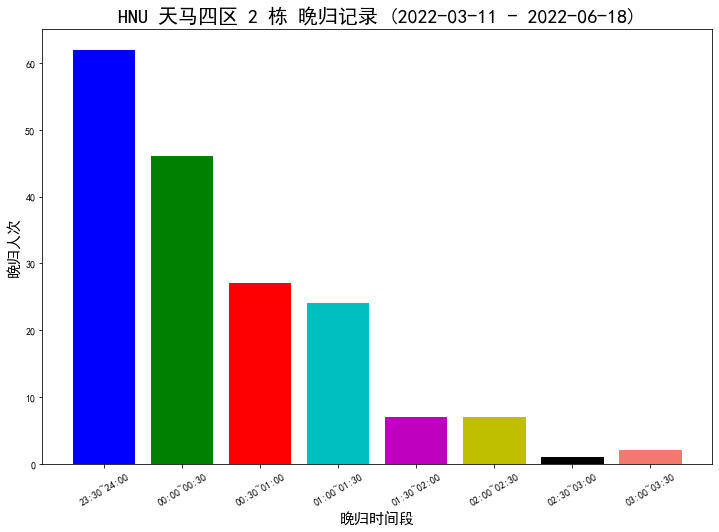

In [9]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#F27970']
g_late = df.groupby(["late"])
tmp = g_late["till"].agg("count")
late = tmp.index
num = tmp.values

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(late))
ax.bar(x, num, color=colors)
_ = ax.set_xticks(x)
_ = ax.set_xticklabels([late_map[e] for e in late], rotation=30)
ax.set_xlabel("晚归时间段", fontsize=15)
ax.set_ylabel("晚归人次", fontsize=15)
ax.set_title(f"HNU 天马四区 2 栋 晚归记录 ({start_date} - {end_date})", fontsize=20)

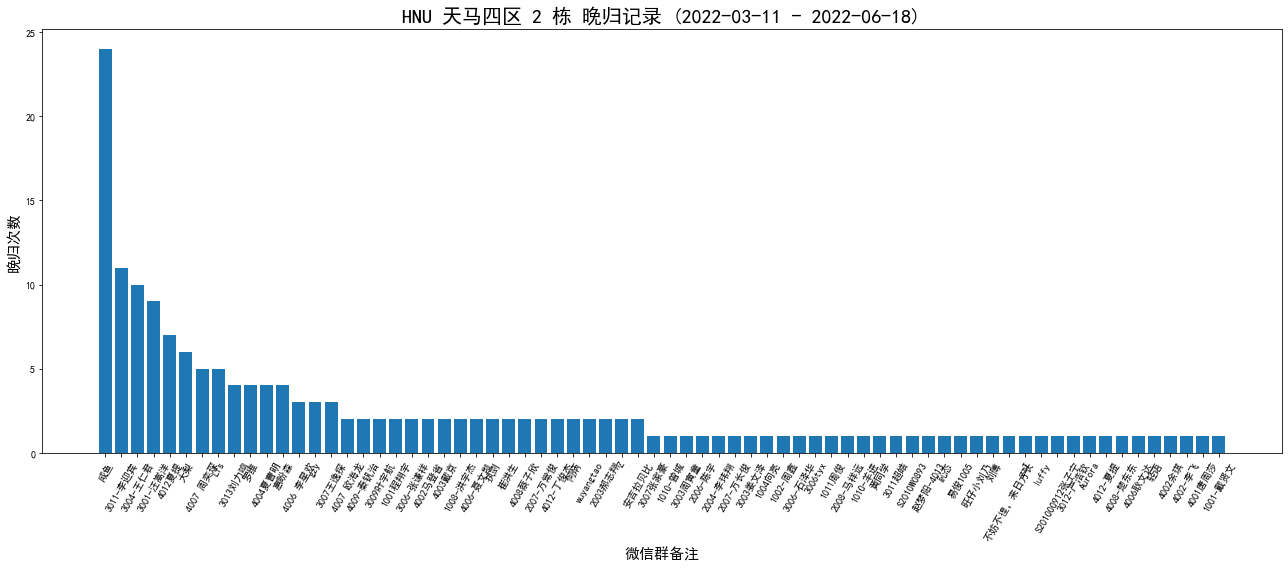

In [10]:
g_nn = df.groupby("nickname")

is_anonymous = False

tmp = g_nn["till"].agg("count").sort_values()[::-1]
nn = tmp.index
num = tmp.values
x = np.arange(len(nn))

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x, num)
_ = ax.set_xticks(x)
ax.set_xticklabels(nn, rotation=60)
fig.tight_layout()
ax.set_xticklabels(nn, rotation=60)
ax.set_xlabel("微信群备注" + ("-anonymous" if is_anonymous else ""), fontsize=15)
ax.set_ylabel("晚归次数", fontsize=15)
ax.set_title(f"HNU 天马四区 2 栋 晚归记录 ({start_date} - {end_date})", fontsize=20)

fig.tight_layout()

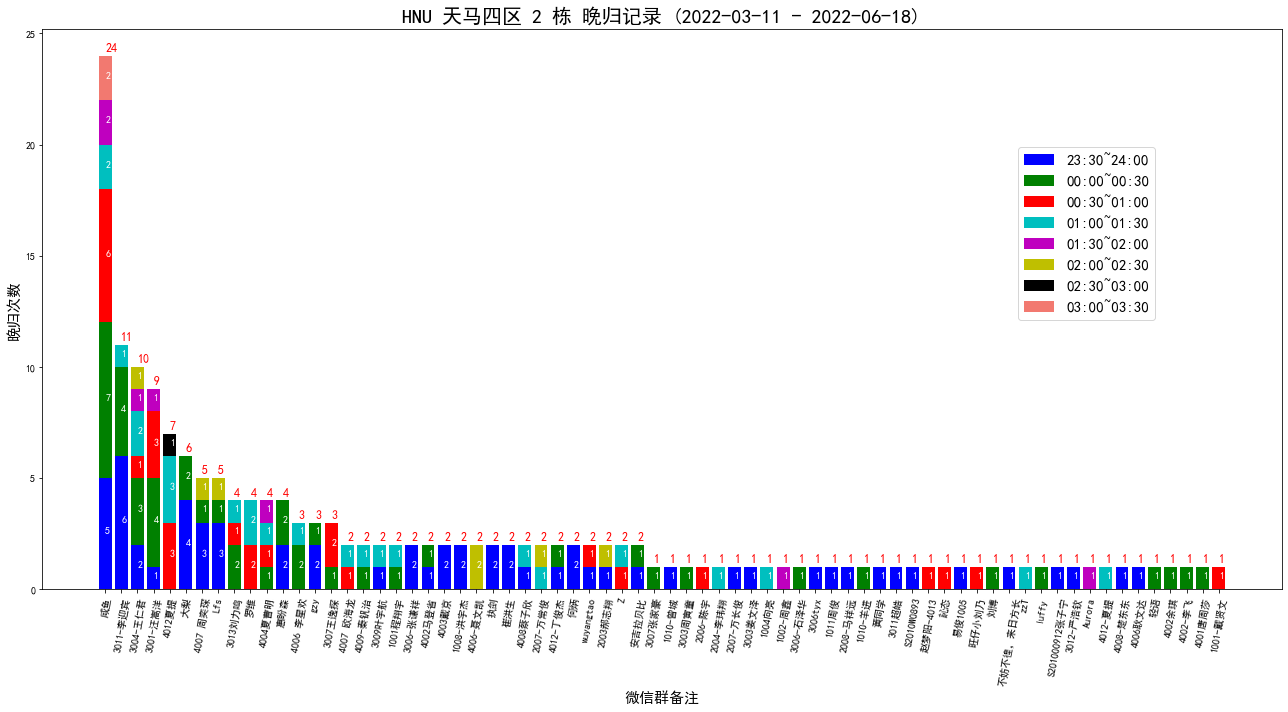

In [11]:
is_anonymous = False
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#F27970']# ['#F27970', '#BB9727', '#54B345', '#32B897', '#05B9E2', '#8983BF', '#C76DA2', '#96CCCB']# ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray'] ['#F27970', '#BB9727', '#54B345', '#32B897', '#05B9E2', '#8983BF', '#C76DA2', '#96CCCB'] 
g_nn = df.groupby("nickname")
tmp = g_nn["till"].agg("count").sort_values()[::-1]
nn = tmp.index

num = tmp.values
x = np.arange(len(nn))
hls = [None]*8

fig, ax = plt.subplots(figsize=(18, 10))

for i, name in enumerate(nn):
#     print(g_nn.get_group(name)["late"].values)
    late_list = g_nn.get_group(name)["late"].values
    c = Counter(late_list)
    tmp = list(c.items())
    tmp = sorted(tmp, key=lambda x: x[0])
    ch = 0
    
    for e in tmp:
        bar = ax.bar(i, e[1], bottom=ch, label=late_map[e[0]], color=colors[e[0]])
        if hls[e[0]] is None:
            hls[e[0]] = bar
        ax.text(i, e[1]/2+ch, str(e[1]), color='white', fontsize=10)
        ch += e[1]
    ax.text(i, ch+0.2, num[i], fontsize=12, color="red")
        
_ = ax.set_xticks(x)
if is_anonymous:
    nn = ['x'*len(e) for e in nn]

ax.set_xticklabels(nn, rotation=80)
ax.set_xlabel("微信群备注" + ("-anonymous" if is_anonymous else ""), fontsize=15)
ax.set_ylabel("晚归次数", fontsize=15)
ax.set_title(f"HNU 天马四区 2 栋 晚归记录 ({start_date} - {end_date})", fontsize=20)

fig.tight_layout()
# ax.legend()
fig.legend(hls, [late_map[i] for i in range(len(late_map))], loc="upper right", bbox_to_anchor=(0.9, 0.8), prop={"size": 15})
fig.savefig("output/" + f"{start_date}~{end_date}" + "晚归次数-微信备注" + ("-anonymous" if is_anonymous else "") + ".png", dpi=400)